<a href="https://colab.research.google.com/github/hyndhavamahesh345/stock-price-prediction-lstm/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-16-464461602.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Epoch 1/30



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.0175 - val_loss: 0.0051
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0022 - val_loss: 8.4096e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.0011 - val_loss: 7.0304e-04
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0011 - val_loss: 5.3971e-04
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0014 - val_loss: 7.5542e-04
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 8.9555e-04 - val_loss: 0.0017
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 8.9263e-04 - val_loss: 0.0024
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


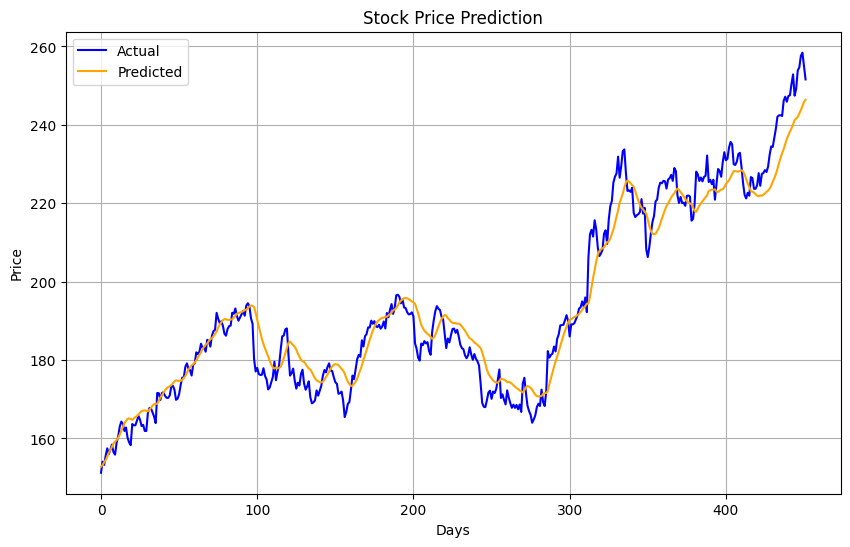

RMSE: 5.52 MAE: 4.36


In [ ]:
# Stock Price Trend Prediction with LSTM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
import plotly.graph_objects as go

# Download Stock Data
data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
data = data[['Close']]
data.dropna(inplace=True)

# Feature Engineering
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['Returns'] = data['Close'].pct_change()
data.dropna(inplace=True)

# Normalize Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Close']])

# Create Sequences
X, y = [], []
window = 60
for i in range(window, len(data_scaled)):
    X.append(data_scaled[i-window:i])
    y.append(data_scaled[i])
X, y = np.array(X), np.array(y)

# Split Data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build Bidirectional LSTM Model with EarlyStopping
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, callbacks=[early_stop])

# Predict & Visualize
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Matplotlib Visualization
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label="Actual", color='blue')
plt.plot(predicted_prices, label="Predicted", color='orange')
plt.title("Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Plotly Advanced Visualization
fig = go.Figure()
fig.add_trace(go.Scatter(y=actual_prices.flatten(), mode='lines', name='Actual'))
fig.add_trace(go.Scatter(y=predicted_prices.flatten(), mode='lines', name='Predicted'))
fig.update_layout(title='LSTM Stock Price Prediction (Interactive)', xaxis_title='Time Step', yaxis_title='Price')
fig.show()

# Evaluate Model
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"RMSE: {rmse:.2f}", f"MAE: {mae:.2f}")
